# PV timeseries clustering

In [3]:
# normal libraries
import numpy as np
import pandas as pd
# Machine learning packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler    
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from tqdm import tqdm
# Plotting and kneed locator
from kneed import KneeLocator, DataGenerator as dg
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
# clear warnings
import warnings
warnings.filterwarnings("ignore")


C:\Users\utente\anaconda3\envs\DATA\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
#  plotting template
nature_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC']
plt.style.use(["science", "nature"])

plt.rcParams.update({"figure.dpi": "200"})
plt.rcParams["figure.constrained_layout.use"] = True

## Importing the data (JRC based-Ancona 1kWp)

In [5]:
# Importing data
df=pd.read_csv("PV_production.csv",index_col=0)
df.dropna(axis=0,inplace=True)
# creating datatimeindex
date_str = '31/12/2020'
start = pd.to_datetime(date_str) - pd.Timedelta(days=365)
hourly_periods = 8784
drange = pd.date_range(start, periods=hourly_periods, freq='H')
# re-name column
df.index=drange

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
P,8784.0,139.764026,210.736583,0.00,0.00,0.000,242.895,796.03
Gb(i),8784.0,113.069160,198.640054,0.00,0.00,0.000,155.010,918.01
Gd(i),8784.0,66.538325,91.274691,0.00,0.00,0.000,119.000,467.00
Gr(i),8784.0,0.000000,0.000000,0.00,0.00,0.000,0.000,0.00
H_sun,8784.0,14.674481,19.543945,0.00,0.00,0.000,26.220,69.81
T2m,8784.0,16.790176,5.779511,5.03,11.62,15.895,22.150,31.42
WS10m,8784.0,4.000897,2.188936,0.00,2.48,3.720,4.970,15.24
Int,8784.0,0.000000,0.000000,0.00,0.00,0.000,0.000,0.00


<AxesSubplot: >

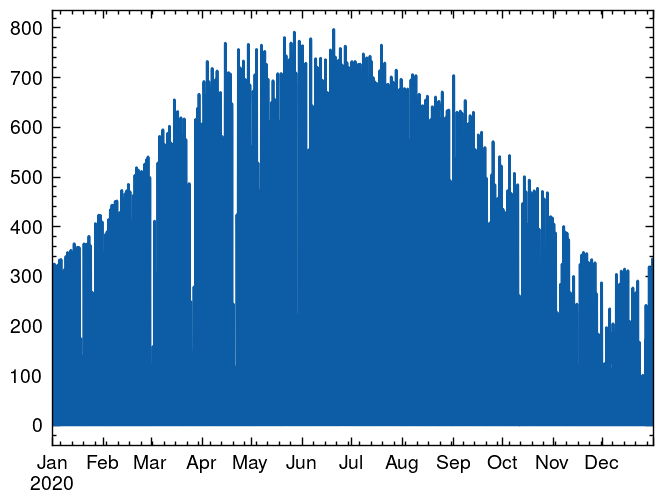

In [7]:
df.P.plot()

## Processing data for Machine learning 

1. Rows as observations (data)
2. columns as features (in this case hours)

In [8]:
df["Days"]=df.index.date


df_grouped=pd.DataFrame()
for i,j in enumerate(df["Days"].unique()):
   df_grouped[i+1]=list(df[df["Days"]==j]["P"])
 
df_grouped.index=np.arange(1,24+1,1)   
df_grouped=df_grouped.T


In [9]:
df_grouped

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.46,112.68,218.82,...,107.15,4.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.46,116.68,227.30,...,111.28,4.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.85,116.31,229.69,...,83.29,6.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.81,66.30,142.72,...,114.00,7.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75,119.36,231.17,...,121.77,9.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.95,50.54,170.15,...,57.98,4.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.29,94.33,97.16,...,31.43,2.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.05,101.83,101.47,...,54.94,6.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.12,29.98,16.88,...,24.46,5.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, '5 Randomly chosen  PV production')

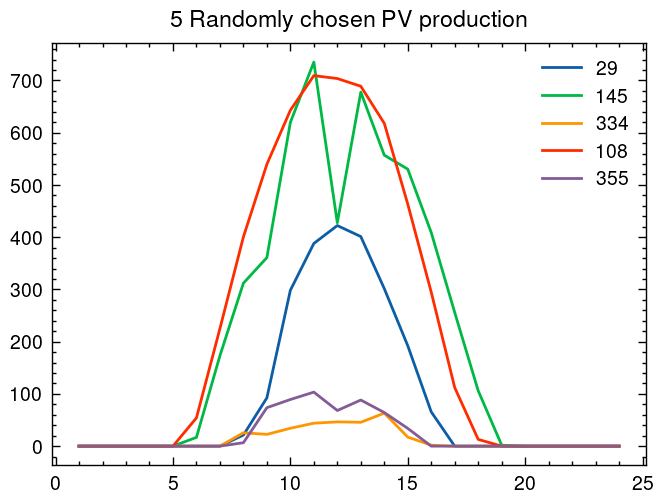

In [10]:
df_grouped.sample(5).T.plot()
plt.title("5 Randomly chosen  PV production")

## Machine learning part

In [11]:
# initialise the data to be used 
X = df_grouped.to_numpy()

X.shape


(366, 24)

In [12]:
from scipy.stats import skew, skewtest
# skew test to see if all features are gaussian
np.abs(skew(X))


array([       nan,        nan,        nan,        nan, 2.60733956,
       1.24572674, 0.60953232, 0.24076334, 0.02540603, 0.16710639,
       0.32872477, 0.36740029, 0.31153369, 0.10091887, 0.0898026 ,
       0.2974453 , 0.64789765, 1.29748207, 2.3824616 ,        nan,
              nan,        nan,        nan,        nan])

In [13]:
# null-hypothesis, all features are simmetrical 
skewtest(X).pvalue


array([           nan,            nan,            nan,            nan,
       2.95168967e-35, 2.14921763e-15, 6.59926726e-06, 5.84978962e-02,
       8.39700529e-01, 1.86145960e-01, 1.06116280e-02, 4.51407327e-03,
       1.52120611e-02, 4.22727117e-01, 4.75385382e-01, 2.02436719e-02,
       2.02461266e-06, 3.35427119e-16, 3.16309015e-32,            nan,
                  nan,            nan,            nan,            nan])

All P-values are extremely low 

let's see from EDA (visualization of data)


(array([156.,  31.,  23.,  18.,  24.,  22.,  25.,  20.,  30.,  17.]),
 array([  0.   ,  33.397,  66.794, 100.191, 133.588, 166.985, 200.382,
        233.779, 267.176, 300.573, 333.97 ]),
 <BarContainer object of 10 artists>)

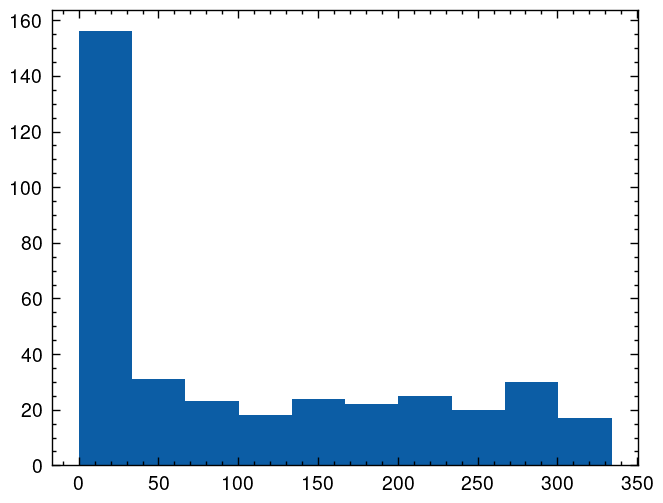

In [14]:
plt.hist(X[:, 6])




(array([99., 46., 28., 18., 26., 21., 32., 34., 39., 23.]),
 array([  0.   ,  49.605,  99.21 , 148.815, 198.42 , 248.025, 297.63 ,
        347.235, 396.84 , 446.445, 496.05 ]),
 <BarContainer object of 10 artists>)

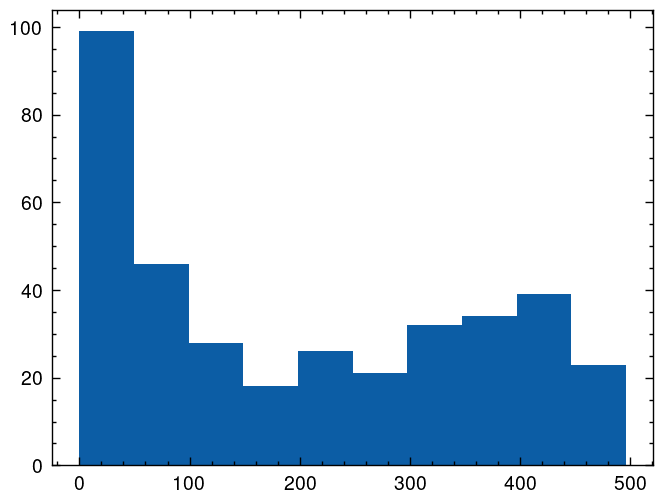

In [15]:
plt.hist(X[:, 7])


As can be seen, are extremely non simmetrical, therefore is required to  have a powertransformation

## Power transformation

In [16]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer()


In [17]:
X = power.fit_transform(X)


In [18]:
skewtest(X).pvalue


array([           nan,            nan,            nan,            nan,
       1.75328668e-19, 2.10703362e-02, 6.61991108e-02, 3.95445652e-02,
       6.44708047e-02, 2.87694245e-02, 1.41998502e-02, 1.08569392e-02,
       4.51690570e-03, 2.75429893e-02, 6.22917968e-02, 1.11270068e-02,
       1.58375599e-01, 5.07926985e-03, 2.11013990e-21,            nan,
                  nan,            nan,            nan,            nan])

Sembrerebbe che non basta powertransformation

(array([111.,   8.,  14.,   8.,  19.,  25.,  25.,  27.,  59.,  70.]),
 array([-1.30840411, -1.04719787, -0.78599163, -0.52478538, -0.26357914,
        -0.0023729 ,  0.25883334,  0.52003958,  0.78124582,  1.04245207,
         1.30365831]),
 <BarContainer object of 10 artists>)

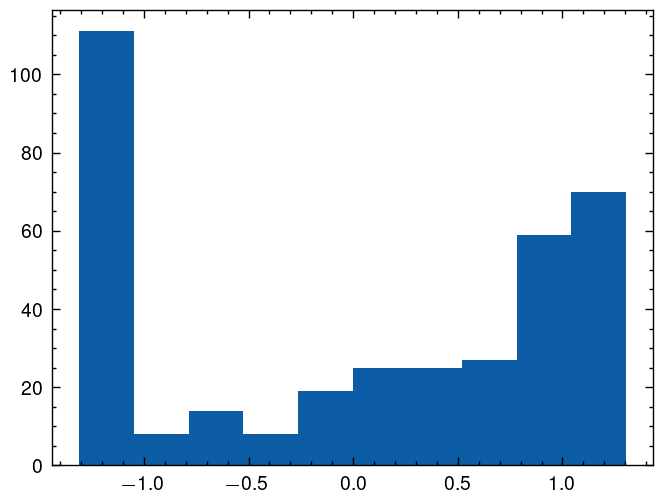

In [19]:
plt.hist(X[:, 6])

Proviamo con standardscaler

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [21]:
X = scaler.fit_transform(X)


In [22]:
skewtest(X).pvalue


array([           nan,            nan,            nan,            nan,
       1.75328668e-19, 2.10703362e-02, 6.61991108e-02, 3.95445652e-02,
       6.44708047e-02, 2.87694245e-02, 1.41998502e-02, 1.08569392e-02,
       4.51690570e-03, 2.75429893e-02, 6.22917968e-02, 1.11270068e-02,
       1.58375599e-01, 5.07926985e-03, 2.11013990e-21,            nan,
                  nan,            nan,            nan,            nan])

(array([111.,   8.,  14.,   8.,  19.,  25.,  25.,  27.,  59.,  70.]),
 array([-1.30840411, -1.04719787, -0.78599163, -0.52478538, -0.26357914,
        -0.0023729 ,  0.25883334,  0.52003958,  0.78124582,  1.04245207,
         1.30365831]),
 <BarContainer object of 10 artists>)

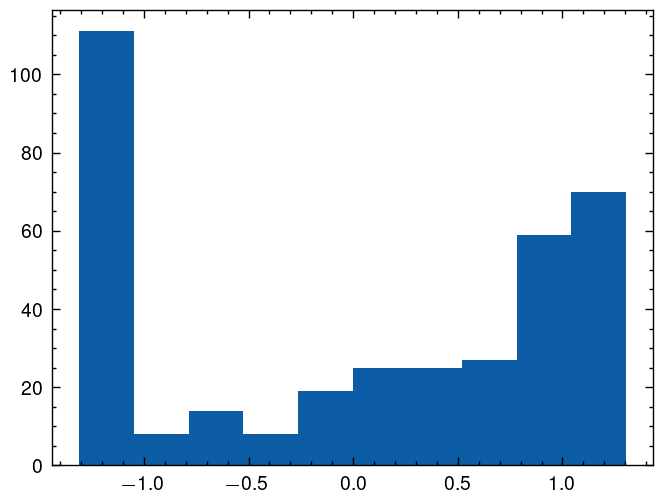

In [23]:
plt.hist(X[:, 6])

 Non basta ancora...

## Proviamo ad inizializzare prima col PCA



In [24]:
X = df_grouped.to_numpy()

In [25]:
from sklearn.decomposition import PCA

pca = PCA()


In [26]:
pca.fit(X)


PCA()

<BarContainer object of 24 artists>

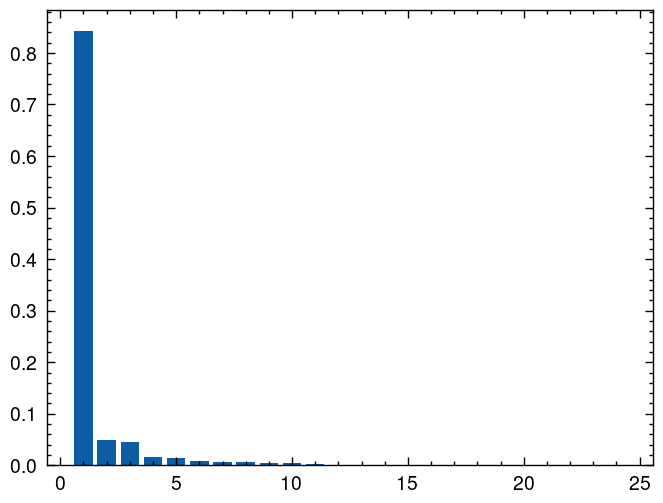

In [27]:
# spiegazione della varianza, per capire fino a quante variabili si può ridurre
x = np.arange(1, X.shape[1] + 1, 1)
y = pca.explained_variance_ratio_ # spiegazione della varianza speigata
plt.bar(x, y)


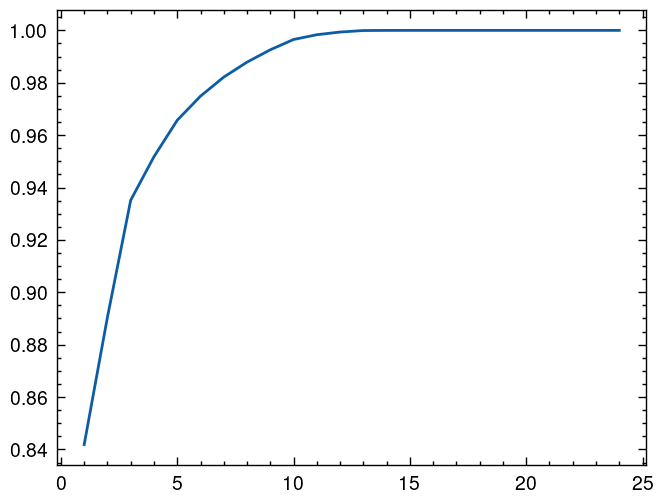

In [28]:
x = np.arange(1, X.shape[1] + 1, 1)
y = np.cumsum(pca.explained_variance_ratio_) # spiegazione della varianza speigata
plt.plot(x, y)

da entrambi sembra che il ginocchio, o quando cambia la curvatura è al 5 features

In [29]:
pca = PCA(n_components=0.95) #95% della varianza


In [30]:
X = pca.fit_transform(X)


In [31]:
X.shape

(366, 4)

In [32]:
X.mean(0)


array([ 9.93983281e-14, -2.95710026e-13, -3.60318939e-14,  1.86371865e-13])

In [33]:
X.std(0)


array([556.96036185, 133.92559107, 128.28244084,  78.26233369])

Sembra che ci sono medie e deviazione standard molto diversi tra le variabili selezionati, quindi sarebbe da fare la stndardizzazione?

In [34]:
np.abs(skew(X))

array([0.00379643, 1.0765872 , 0.68691104, 0.08562592])

In [35]:
skewtest(X).pvalue


array([9.75883024e-01, 9.22087098e-13, 5.90345386e-07, 4.96083679e-01])

In [36]:
power = PowerTransformer()
X = power.fit_transform(X)

In [37]:
skewtest(X).pvalue


array([0.7322724 , 0.56483577, 0.09001792, 0.18483801])

Skewtest passato (quindi sono simmetriche?)

(array([34., 50., 44., 30., 25., 32., 41., 42., 37., 31.]),
 array([-1.69568574, -1.3480062 , -1.00032666, -0.65264712, -0.30496758,
         0.04271196,  0.3903915 ,  0.73807103,  1.08575057,  1.43343011,
         1.78110965]),
 <BarContainer object of 10 artists>)

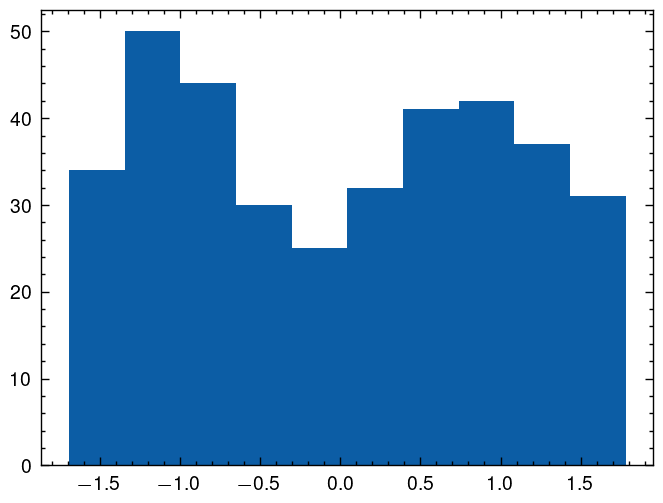

In [38]:
plt.hist(X[:,0])

(array([  6.,   7.,  11.,  40., 169., 100.,  22.,   3.,   5.,   3.]),
 array([-3.74436485, -2.94972108, -2.15507732, -1.36043355, -0.56578979,
         0.22885397,  1.02349774,  1.8181415 ,  2.61278527,  3.40742903,
         4.20207279]),
 <BarContainer object of 10 artists>)

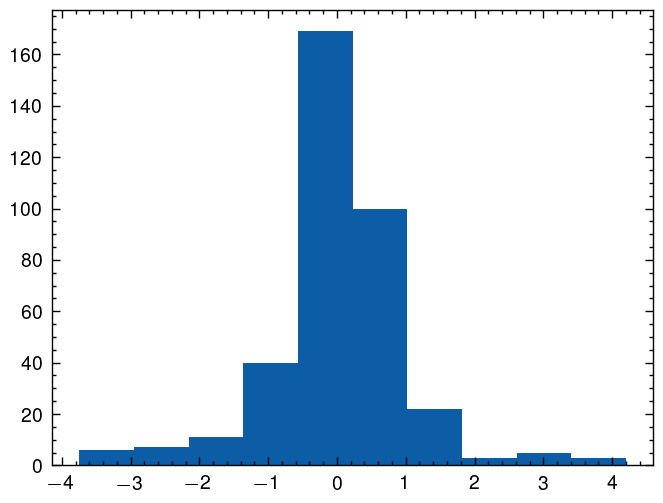

In [39]:
plt.hist(X[:,1])

(array([  2.,   8.,  60.,  80.,  58., 100.,  46.,   5.,   5.,   2.]),
 array([-2.92023154, -2.27230015, -1.62436876, -0.97643737, -0.32850598,
         0.31942541,  0.9673568 ,  1.61528819,  2.26321958,  2.91115097,
         3.55908236]),
 <BarContainer object of 10 artists>)

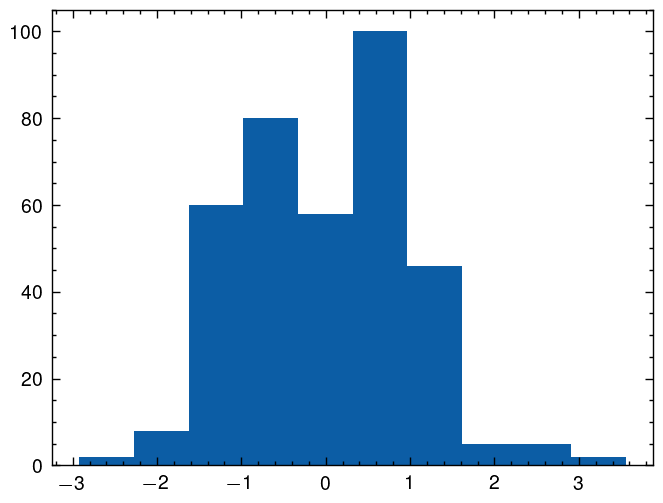

In [40]:
plt.hist(X[:,2])

(array([  4.,   7.,  10.,  33., 191.,  96.,  14.,   4.,   5.,   2.]),
 array([-4.13451062, -3.26385034, -2.39319006, -1.52252979, -0.65186951,
         0.21879077,  1.08945104,  1.96011132,  2.8307716 ,  3.70143187,
         4.57209215]),
 <BarContainer object of 10 artists>)

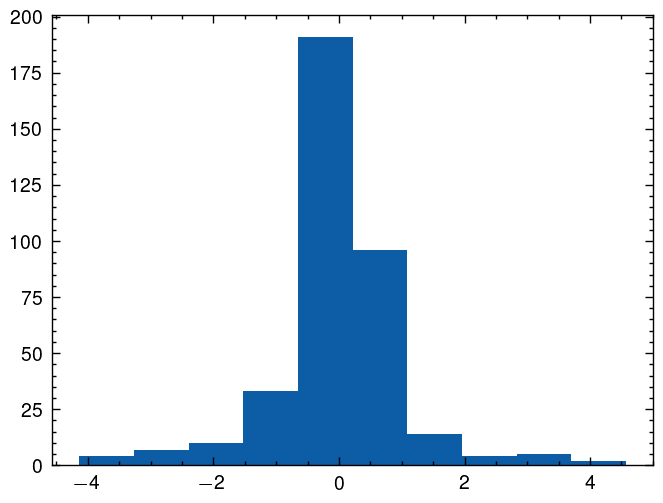

In [41]:
plt.hist(X[:,3])

In [42]:
X.mean(0)

array([ 1.94137359e-17,  0.00000000e+00,  1.94137359e-17, -4.85343399e-18])

In [43]:
X.std(0)


array([1., 1., 1., 1.])

già fatta la standardizzazione con la powertransformation

## Ricominciamo

In [44]:
X = df_grouped.to_numpy()

In [45]:
from sklearn.pipeline import make_pipeline, Pipeline


preprocessing = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('power', PowerTransformer())
    
])

# preprocessing=make_pipeline(
#  PCA(n_components=0.95),
#  PowerTransformer())

In [46]:
X_processed=preprocessing.fit_transform(X)

In [47]:
X_processed.mean(0)

array([ 1.94137359e-17,  0.00000000e+00,  1.94137359e-17, -4.85343399e-18])

In [48]:
X_processed.std(0)


array([1., 1., 1., 1.])

In [49]:
X_original=preprocessing.inverse_transform(X_processed)

In [50]:
X_original.shape


(366, 24)

## Clustering part

Initialise and test the k-means

In [51]:
cluster = KMeans(n_clusters=2,init = 'k-means++', max_iter=300, n_init=10, random_state=0)

In [52]:
cluster.fit(X_processed)
wcss_iter = cluster.inertia_

In [53]:
wcss_iter

1157.6753137726034

In [54]:
# see some results as how is distributed the samples in clusters
labels = cluster.fit_predict(X_processed)

sil_media = silhouette_score(X, labels)

samp = silhouette_samples(X, labels)
print(np.mean(samp[labels == 0] > sil_media),np.mean(samp[labels == 1] > sil_media))

0.6244131455399061 0.7450980392156863


In [55]:
# trying Elbow and Silhoutte
Cluster_max=45
##%%
wcss=[]
Silhoutte = []
davis=[]


for i in tqdm(range(2,Cluster_max)):
    cluster = KMeans(n_clusters=i,init = 'k-means++', max_iter=300, n_init=10, random_state=0)


    cluster.fit(X_processed)
    wcss_iter = cluster.inertia_
    wcss.append(wcss_iter)
    labels = cluster.fit_predict(X_processed)
    
    Silhoutte.append(silhouette_score(X_processed, labels))
    davis.append(davies_bouldin_score(X_processed, labels))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 43/43 [01:46<00:00,  2.48s/it]


Text(0, 0.5, 'Davis')

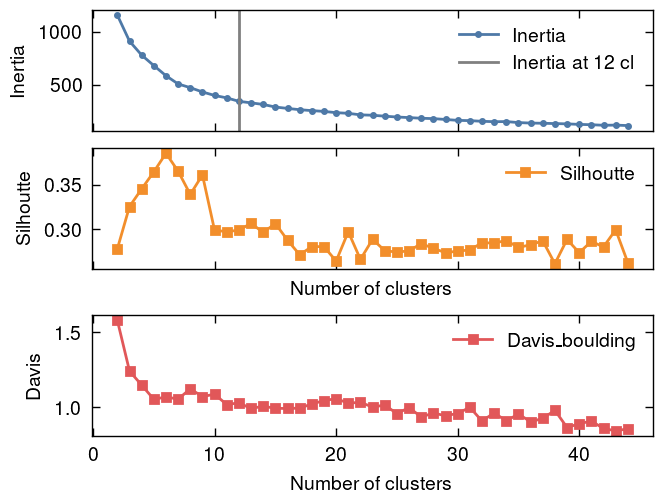

In [56]:
number_clusters = range(2,Cluster_max)


kl = KneeLocator(number_clusters,wcss, curve="convex", direction="decreasing")

fig1,ax=plt.subplots(nrows=3, ncols=1,sharex=True)
ax[0].plot(number_clusters,wcss,marker=".",label="Inertia",color=nature_colors[0])
ax[0].axvline(x=kl.knee,color="gray",label=f"Inertia at {kl.knee} cl")

ax[0].set_ylabel('Inertia')
ax[0].legend()
ax[0].tick_params(which='minor', bottom=False, top=False, right=False, left=False)



ax[1].plot(number_clusters,Silhoutte,marker="s",label="Silhoutte",color=nature_colors[1])
ax[1].legend()
ax[1].set_xlabel('Number of clusters')
# ax[1].grid()
ax[1].tick_params(which='minor', bottom=False, top=False, right=False, left=False)
ax[1].legend()
ax[1].set_ylabel("Silhoutte")



ax[2].plot(number_clusters,davis,marker="s",label="Davis_boulding",color=nature_colors[2])
ax[2].legend()
ax[2].set_xlabel('Number of clusters')
# ax[1].grid()
ax[2].tick_params(which='minor', bottom=False, top=False, right=False, left=False)
ax[2].legend()
ax[2].set_ylabel("Davis")



In [57]:
cluster = KMeans(n_clusters=kl.knee,random_state=0)
cluster.fit(X_processed)
labels = cluster.fit_predict(X_processed)

np.unique(labels, return_counts=True) # number of elements in each clusters


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([54, 60, 43, 14,  6, 37, 47,  7, 12,  9,  4, 73], dtype=int64))

<BarContainer object of 12 artists>

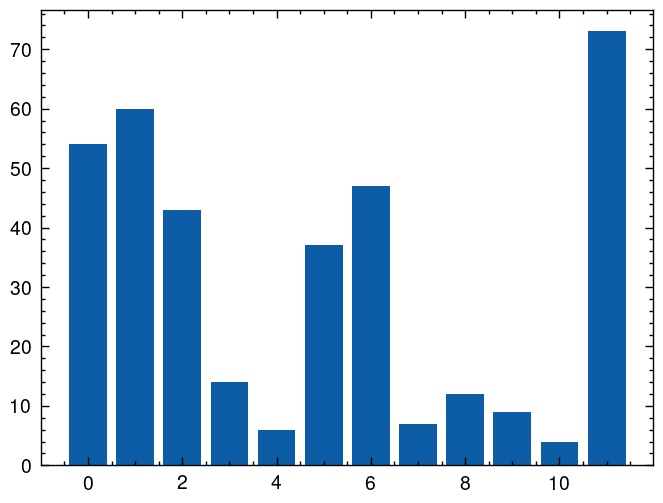

In [58]:
#distrbution of data clustered
plt.bar(np.unique(labels, return_counts=True)[0],np.unique(labels, return_counts=True)[1])
# plt.xlabel("cluster")
# plt.ylabel("Number of records per cluster")
# plt.title("#n series in a cluster")


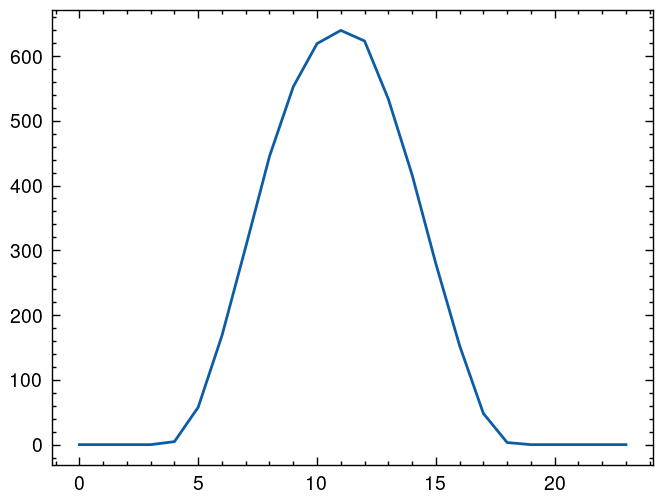

In [59]:
plt.plot(preprocessing.inverse_transform(cluster.cluster_centers_)[0])

Text(0.5, 0.98, 'Euclidean $k$-means using scikit-learn and inversed back')

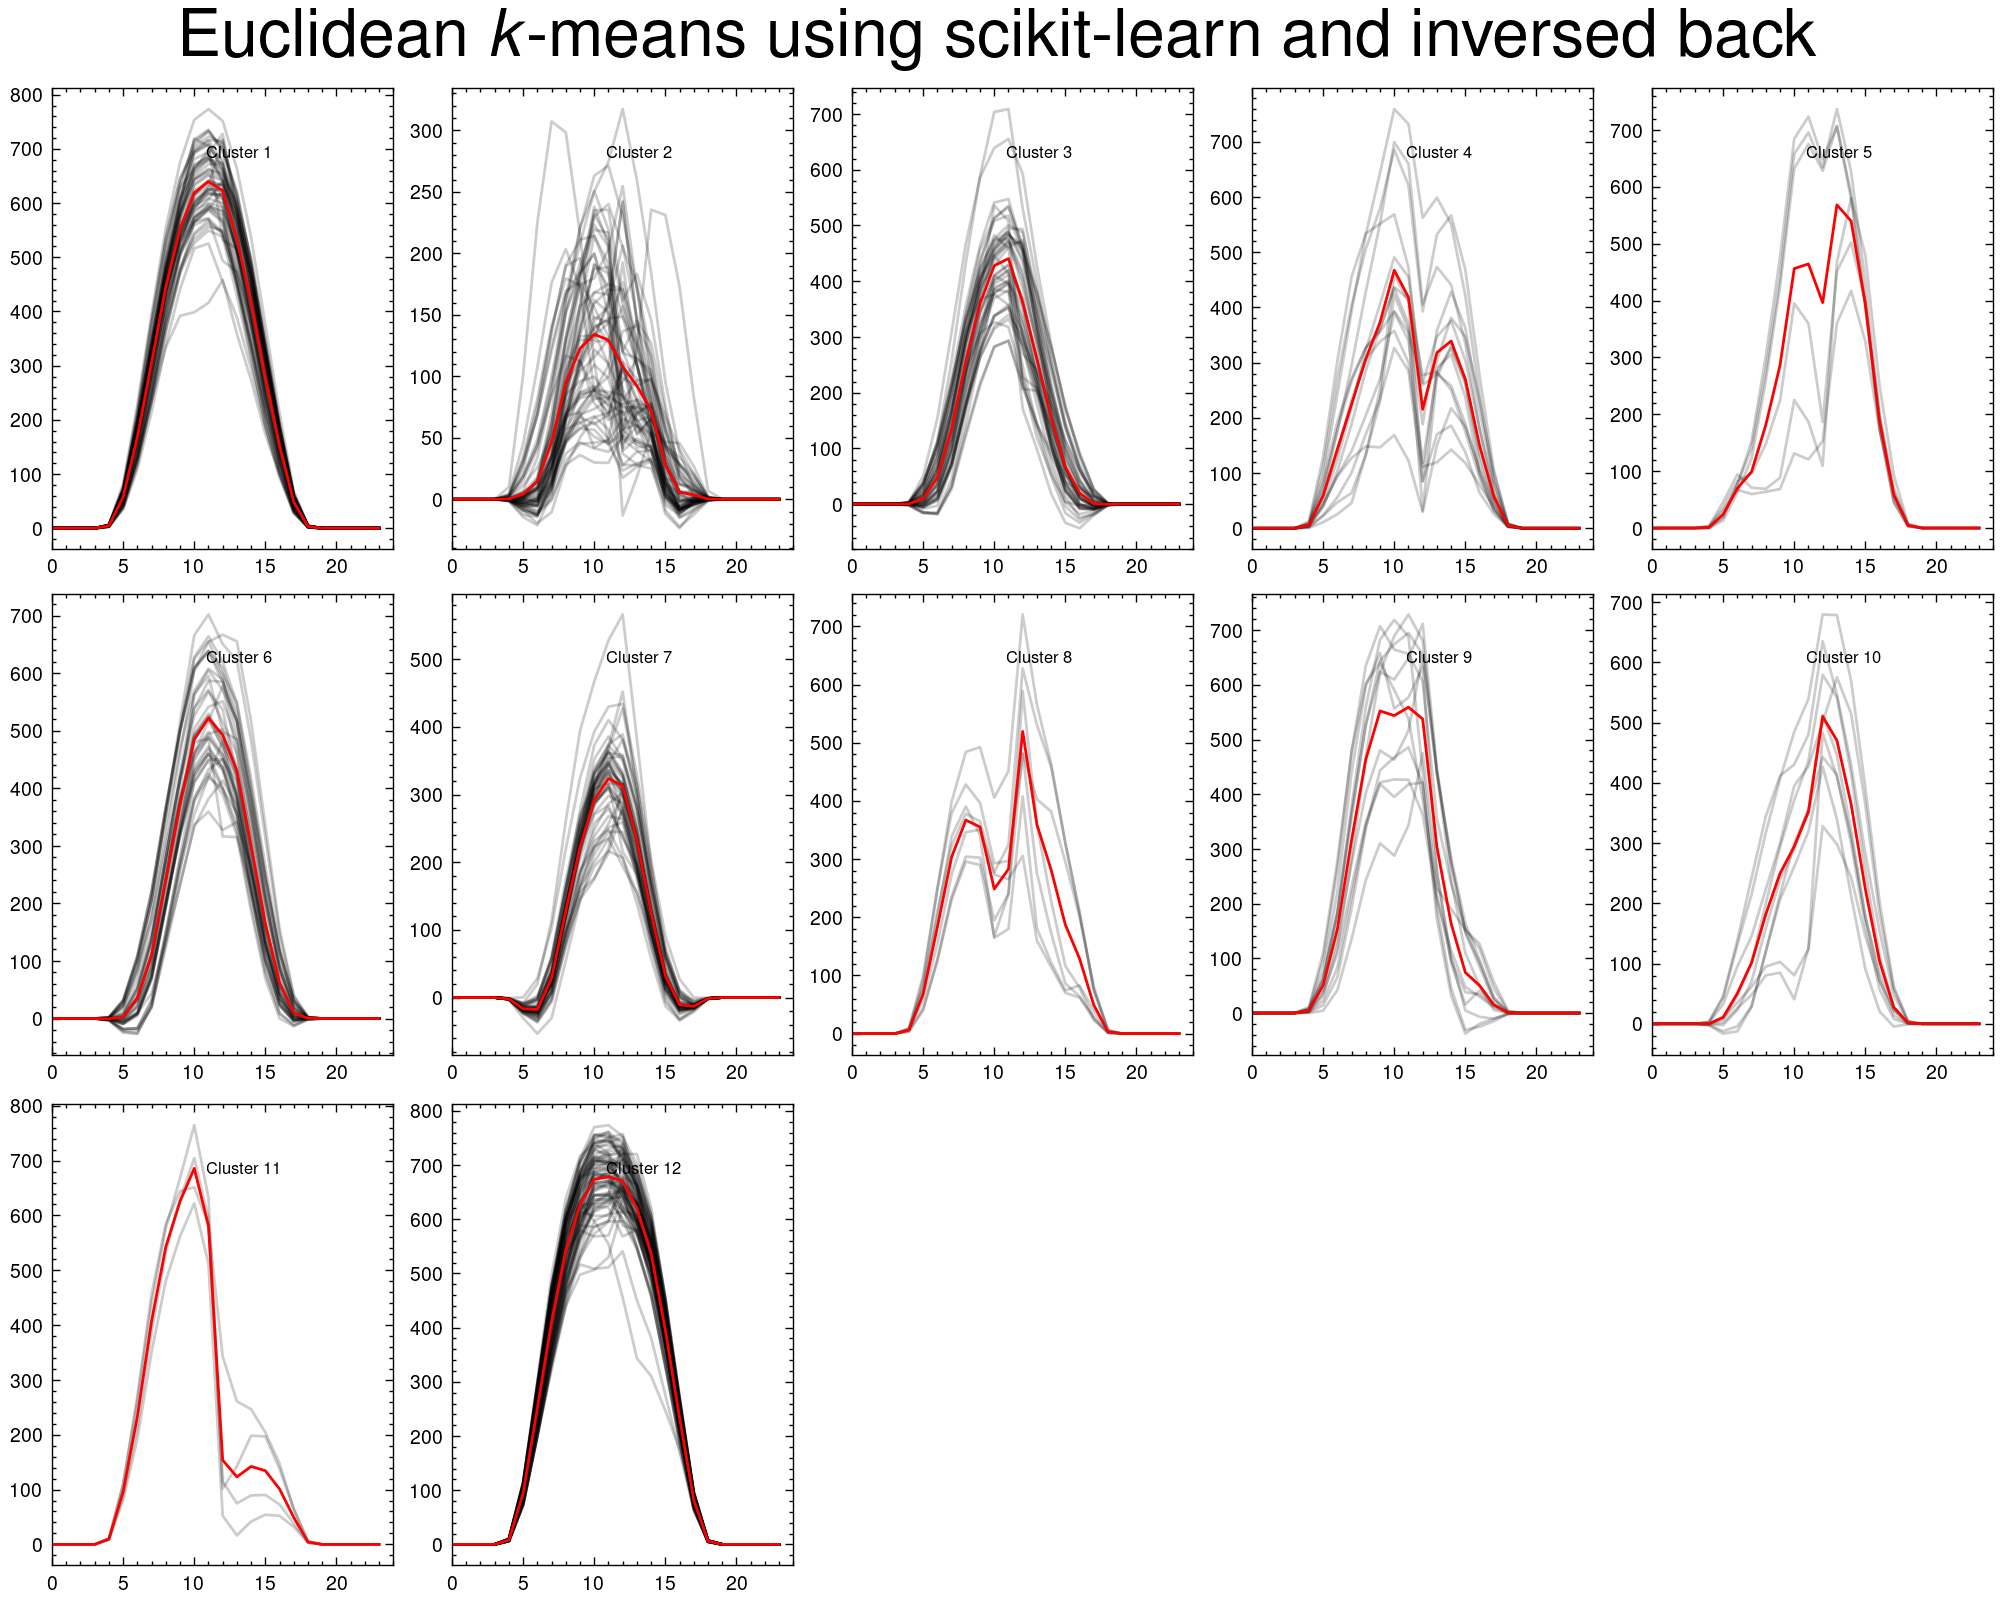

In [60]:
# plotting


cluster = KMeans(n_clusters=kl.knee,init = 'k-means++', max_iter=300, n_init=10, random_state=0)

y_pred = cluster.fit_predict(X_processed)

X_back=preprocessing.inverse_transform(X_processed)
X_centers=preprocessing.inverse_transform(cluster.cluster_centers_)

plt.figure(888,figsize=(10,8))
for yi in range(kl.knee):
    plt.subplot(3, (kl.knee//3)+1, yi + 1)
    for xx in X_back[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(X_centers[yi].ravel(), "r-")
    plt.text(0.45, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes,fontsize=6)
    plt.xlim(0, 24)
   
#     if yi == 1:
#         plt.title("Euclidean $k$-means using scikit-learn \n and inversed back")
        
        
plt.suptitle("Euclidean $k$-means using scikit-learn and inversed back",fontsize=24)

In [61]:
# saving results

data_centroid=pd.DataFrame(index=np.arange(1,24+1,1))
for i in np.arange(0,X_centers.shape[0],1):
    data_centroid[f"cluster {i+1}"]=X_centers[i,:]
# X_centers

In [62]:
data_centroid

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,5.108234e-14,-8.833616e-14,-2.798098e-14,-4.738852e-15,3.561240e-14,8.390250e-15,-5.089925e-14,-1.323350e-14,-8.499864e-16,5.650979e-16,-1.517989e-14,7.968445e-14
3,9.824328e-15,-2.545349e-14,-2.034163e-15,4.657011e-14,5.605533e-14,1.112746e-14,-1.531682e-14,-7.665263e-14,-2.880418e-14,-2.630132e-14,5.735346e-14,1.671225e-14
4,8.893143e-16,3.027447e-15,2.660229e-15,-1.688320e-14,-4.257222e-14,-1.137181e-14,-2.273084e-15,3.214781e-14,2.871011e-14,-6.285265e-15,1.001961e-14,1.248821e-15
5,4.639697e+00,3.879415e-01,5.948930e-01,5.331091e+00,1.103417e+00,-6.290862e-01,-2.052313e+00,6.080883e+00,4.582054e+00,2.575038e-02,9.685576e+00,8.052766e+00
6,5.774596e+01,4.221910e+00,1.020948e+01,5.917421e+01,2.419887e+01,2.705223e+00,-1.660990e+01,6.803838e+01,5.070852e+01,1.083995e+01,9.638691e+01,9.412119e+01
7,1.683001e+02,1.461376e+01,4.776536e+01,1.433475e+02,6.976389e+01,3.601963e+01,-1.766529e+01,1.830119e+02,1.534970e+02,5.052092e+01,2.334746e+02,2.511061e+02
8,3.053384e+02,4.638779e+01,1.354065e+02,2.245556e+02,9.911089e+01,1.108720e+02,2.850374e+01,3.032744e+02,3.161676e+02,1.014276e+02,4.072456e+02,4.111882e+02
9,4.450647e+02,9.484409e+01,2.565906e+02,3.067605e+02,1.812849e+02,2.408903e+02,1.278555e+02,3.668818e+02,4.636478e+02,1.818714e+02,5.428801e+02,5.419309e+02
10,5.525252e+02,1.224745e+02,3.598239e+02,3.730697e+02,2.862288e+02,3.706589e+02,2.222322e+02,3.552171e+02,5.523160e+02,2.495901e+02,6.255903e+02,6.265756e+02


<AxesSubplot: >

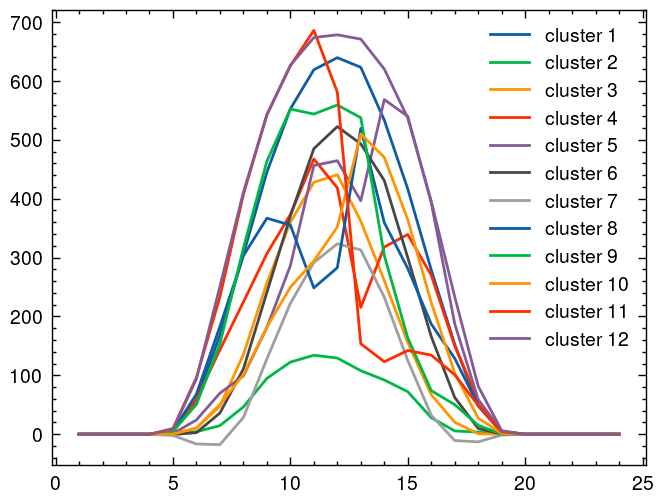

In [63]:
data_centroid.plot()

In [64]:
# data_centroid.to_csv("k-means.csv")

## ML using DBSCAN

In [85]:
from sklearn.cluster import DBSCAN

In [77]:
X = df_grouped.to_numpy()

In [73]:
X.shape

(366, 24)

In [78]:
power = PowerTransformer()

In [79]:
# X = power.fit_transform(X)
X_processed=preprocessing.fit_transform(X)


In [80]:
X_processed

array([[ 0.90901298, -0.26931597, -0.87558463, -0.07619286],
       [ 0.88723344, -0.28346321, -0.90552486, -0.03378442],
       [ 0.9845522 ,  0.1083124 , -0.57406595, -0.84179311],
       ...,
       [ 1.11900555, -0.17202674, -0.70821633,  0.26267904],
       [ 1.23298714, -0.69824817, -0.62350266,  0.01899184],
       [ 0.89809859, -0.32437793, -0.99010394, -0.09561602]])

In [83]:
X_processed.mean(0)

array([ 1.94137359e-17,  0.00000000e+00,  1.94137359e-17, -4.85343399e-18])

In [84]:
X_processed.std(0)

array([1., 1., 1., 1.])

In [86]:
cluster = DBSCAN(min_samples=2, eps=0.5) # numero minimo di record ed epsilon /distanza

In [87]:
cluster.fit_predict(X_processed)

array([ 0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1, -1, -1,  0,
        0,  0, -1,  0, -1, -1, -1,  0, -1,  0,  0, -1, -1,  1, -1, -1,  2,
       -1,  0,  2,  0,  3, -1,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1, -1,
        0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1, -1,  4,  0, -1,  0,  0,  0,  0, -1, -1,
       -1, -1, -1,  0, -1,  0, -1, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0,  0,  0,  5,  6,  0,  0,  0, -1,  0,  7, -1, -1,
        0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1,  5, -1,  0,  0,
        0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,
        0,  8,  6,  9,  0,  0,  0,  0,  0,  0, -1,  9,  8, -1,  0,  0,  0,
        0,  0,  0,  0,  0

 A lor of outliers... maybe is not the case to use DBSCAN

In [89]:
np.unique(cluster.fit_predict(X_processed), return_counts=True) # conta il numero di unique

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([103, 240,   2,   2,   2,   2,   2,   2,   2,   2,   2,   5],
       dtype=int64))

Text(0, 0.5, 'observation per cluster')

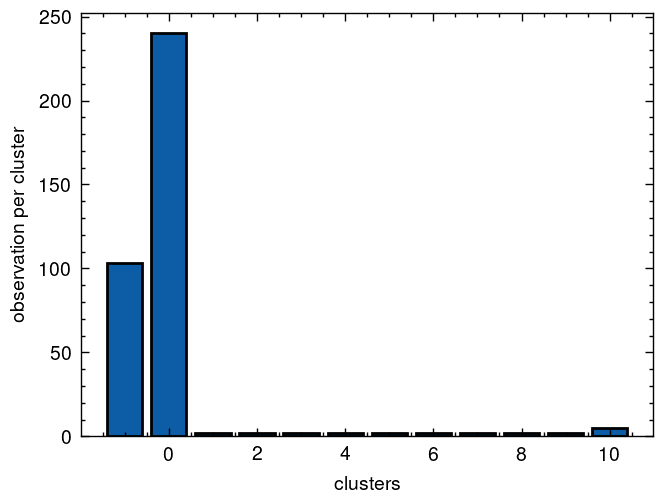

In [94]:
plt.bar(np.unique(cluster.fit_predict(X_processed), return_counts=True)[0],np.unique(cluster.fit_predict(X_processed), return_counts=True)[1],
       edgecolor="k")
plt.xlabel("clusters")
plt.ylabel("observation per cluster")

Tuning per epsilon

In [95]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=2)

In [96]:
nn.fit(X_processed)


NearestNeighbors(n_neighbors=2)

In [98]:
distances, indices = nn.kneighbors(X_processed) # prende con i record va a calcolare i due primi vicini e calcola la dist

In [99]:
distances

array([[0.        , 0.05804641],
       [0.        , 0.05804641],
       [0.        , 0.5045935 ],
       [0.        , 0.30353671],
       [0.        , 0.05429218],
       [0.        , 0.22575925],
       [0.        , 0.10409834],
       [0.        , 0.57386526],
       [0.        , 0.09088942],
       [0.        , 0.09181231],
       [0.        , 0.05429218],
       [0.        , 0.28042254],
       [0.        , 0.08309775],
       [0.        , 0.10142014],
       [0.        , 0.08309775],
       [0.        , 0.14954822],
       [0.        , 0.08406681],
       [0.        , 0.17677269],
       [0.        , 0.26999545],
       [0.        , 0.1119835 ],
       [0.        , 0.08406681],
       [0.        , 0.35676347],
       [0.        , 0.1119835 ],
       [0.        , 0.16596665],
       [0.        , 0.18473006],
       [0.        , 0.19852983],
       [0.        , 0.23189098],
       [0.        , 0.31818043],
       [0.        , 0.2506523 ],
       [0.        , 0.2506523 ],
       [0.

In [100]:
indices

array([[  0,   1],
       [  1,   0],
       [  2, 346],
       [  3, 364],
       [  4,  10],
       [  5,  10],
       [  6, 343],
       [  7, 353],
       [  8,   4],
       [  9,   8],
       [ 10,   4],
       [ 11,  12],
       [ 12,  14],
       [ 13,   9],
       [ 14,  12],
       [ 15,  16],
       [ 16,  20],
       [ 17, 104],
       [ 18, 149],
       [ 19,  22],
       [ 20,  16],
       [ 21,  23],
       [ 22,  19],
       [ 23,  22],
       [ 24, 276],
       [ 25, 349],
       [ 26,  22],
       [ 27, 352],
       [ 28,  29],
       [ 29,  28],
       [ 30,  83],
       [ 31, 316],
       [ 32,   5],
       [ 33,  32],
       [ 34, 288],
       [ 35,  49],
       [ 36,  38],
       [ 37,  36],
       [ 38,  36],
       [ 39,  51],
       [ 40,  53],
       [ 41,  42],
       [ 42,  43],
       [ 43,  45],
       [ 44,  53],
       [ 45,  46],
       [ 46,  45],
       [ 47,  43],
       [ 48,   7],
       [ 49,  33],
       [ 50,  54],
       [ 51,  46],
       [ 52,

In [101]:
distances = np.sort(distances[:, -1])

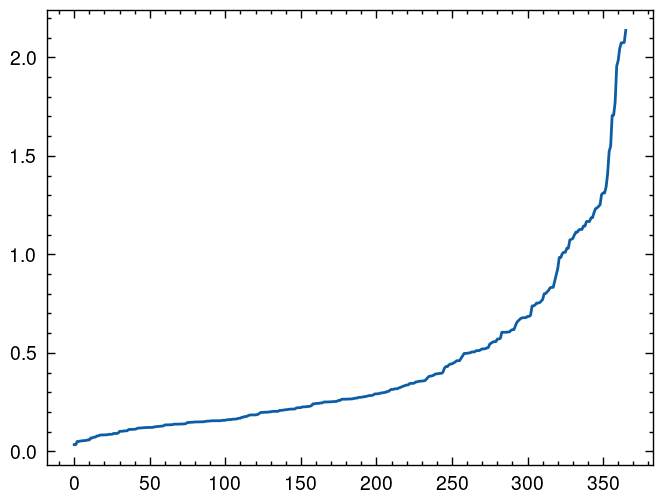

In [103]:
x = range(len(distances))
y = distances
plt.plot(x, y)

need to find the maximum accelaration

In [115]:
import kneed # ginocchio

kneedle = kneed.KneeLocator(
 x, y, curve="convex", direction="increasing"
) #

In [116]:
kneedle.knee_y # trovata l'ordinata, ovvero epsilon


2.0758289657032045

In [110]:
kneedle.elbow  #(X)

364

Retry DBSCAN

In [121]:
epsilon = kneedle.knee_y
cluster = DBSCAN(eps=0.6, min_samples=2)
labels = cluster.fit_predict(X_processed)



In [122]:
np.unique(labels, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 83, 273,   2,   2,   2,   2,   2], dtype=int64))

In [123]:
df = pd.DataFrame(
 columns=["lables", "counts"],
 data=np.array(np.unique(labels, return_counts=True)).T,
)


In [125]:
df

,lables,counts
0,-1,83
1,0,273
2,1,2
3,2,2
4,3,2
5,4,2
6,5,2


**DBSAN not suitable!!**